### Data Analysis

#### Initial Dependencies

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns

# ignore some warnings if dataframe is changing
import warnings
warnings.filterwarnings('ignore')

#### Preview DataFrame

In [2]:
df = pd.read_csv("output_data/cleanup_movie_2019.csv")
df.columns

Index(['Title', 'Adult', 'Budget', 'Genres', 'Production Company',
       'Popularity', 'Revenue', 'Production Country', 'Run Time',
       'Vote Average', 'Vote Count', 'Genre1', 'Genre2', 'Genre3', 'Genre4',
       'Genre5', 'Genre6', 'Genre7', 'Rated', 'omdb_released', 'omdb_runtime',
       'Director', 'Actors', 'Language', 'omdb_country', 'Metascore',
       'IMDB Rating', 'IMDB Votes'],
      dtype='object')

#### Release Date vs Movie Runtime

In [3]:
clean_df = df[['Title','Genres','omdb_released','omdb_runtime','omdb_country',
               'IMDB Rating','IMDB Votes','Revenue']]

In [4]:
clean_df.head(1)

,Title,Genres,omdb_released,omdb_runtime,omdb_country,IMDB Rating,IMDB Votes,Revenue
0,Joker,"['Crime', 'Thriller', 'Drama']",04 Oct 2019,122 min,"USA, Canada",8.9,"360,218",788300000.0


In [5]:
clean_df['omdb_released'] =  pd.to_datetime(clean_df['omdb_released'])
print(clean_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 8 columns):
Title            9997 non-null object
Genres           9997 non-null object
omdb_released    9617 non-null datetime64[ns]
omdb_runtime     9531 non-null object
omdb_country     9665 non-null object
IMDB Rating      9557 non-null float64
IMDB Votes       9557 non-null object
Revenue          2943 non-null float64
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 624.9+ KB
None


In [6]:
clean_df = clean_df.dropna(how='any').sort_values('omdb_released',ascending=True)
clean_df = clean_df.rename(columns={'omdb_title':'Title','omdb_released':'Release Date',
                                    'omdb_runtime':'Runtime (min)','omdb_country':'Country',
                                    'omdb_imdbRating':'imdb_Rating','omdb_imdbVotes':'imdb_Votes'})

clean_df = clean_df[clean_df['Release Date'].isin(pd.date_range(start='2009', end='20191028'))]

In [7]:
clean_df['Runtime (min)'] = clean_df['Runtime (min)'].str.replace(' min','').astype(np.uint8)

In [8]:
clean_df = clean_df[clean_df.Country.str.contains("USA")]

In [9]:
group_mean_df = clean_df[['Release Date', 'Runtime (min)']]
group_mean_df['Release Date'] = group_mean_df['Release Date'].dt.strftime('%Y')
group_mean_df = group_mean_df.groupby('Release Date').mean().reset_index()

In [10]:
avg_runtime = clean_df['Runtime (min)'].mean()
print(avg_runtime)

106.31640808650681


In [11]:
group_all_df = clean_df[['Release Date', 'Runtime (min)']]

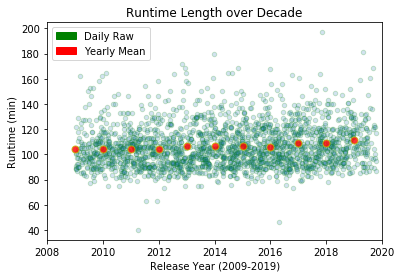

In [12]:
plt.scatter(group_all_df['Release Date'],group_all_df['Runtime (min)'], alpha=0.2,edgecolors='g',s=20 )
plt.scatter(group_mean_df['Release Date'],group_mean_df['Runtime (min)'],alpha=0.8,c='r',edgecolors='y',s=50)
plt.xlabel('Release Year (2009-2019)')
plt.xlim('2008','2020')
plt.ylabel('Runtime (min)')
plt.title('Runtime Length over Decade')
green_scatter = mpatches.Patch(color='g', label='Daily Raw')
red_scatter = mpatches.Patch(color='r', label='Yearly Mean')
plt.legend(handles=[green_scatter,red_scatter])

plt.savefig("Output_Data/Release_vs_Runtime.png")

plt.show()

* Green scatters are individual year-month-day data since 2009 to today.
* Red scatter points are mean value per year.
* Deep dark green areas coincide well with red areas showing that over the decade runtime has always been steady in its place around 100 minutes.

#### Release Date vs Movie Genre

In [13]:
clean_df.head()

,Title,Genres,Release Date,Runtime (min),Country,IMDB Rating,IMDB Votes,Revenue
1467,Bride Wars,"['Comedy', 'Romance']",2009-01-09,89,USA,5.5,"95,747",114663461.0
1966,The Unborn,"['Horror', 'Thriller', 'Mystery']",2009-01-09,88,USA,4.8,"47,407",76514050.0
2429,Hotel for Dogs,"['Comedy', 'Family']",2009-01-16,100,"Germany, USA",5.4,"20,204",117000198.0
3920,My Bloody Valentine,"['Mystery', 'Horror']",2009-01-16,101,USA,5.4,"51,333",102836002.0
2704,Notorious,"['Drama', 'Music', 'History']",2009-01-16,122,USA,6.7,"38,659",43051547.0


In [14]:
genre_df = clean_df[['Release Date','Genres']]
new_df= pd.DataFrame(genre_df.Genres.str.split(",").tolist(), index=genre_df['Release Date']).stack()
new_df = new_df.str.replace(r'[^a-zA-Z]\s?',r'',regex=True)

In [15]:
genre_date_df = new_df.reset_index([0,'Release Date'])
genre_date_df.columns = ['Release Date','Genres']
genre_date_df['Release Date'] = genre_date_df['Release Date'].dt.strftime('%Y')

In [16]:
genre_date_df['Genres'].replace('', np.nan, inplace=True)
genre_date_df.dropna(subset=['Genres'],inplace=True,how='any')

In [17]:
group_genre_df = genre_date_df.groupby('Release Date')['Genres'].value_counts()
group_genre_df = group_genre_df.to_frame(name='Total Count').reset_index()
group_genre_df.head()

,Release Date,Genres,Total Count
0,2009,Comedy,67
1,2009,Drama,60
2,2009,Thriller,49
3,2009,Action,38
4,2009,Adventure,32


In [18]:
group_genre_pivot = group_genre_df.pivot(index='Genres',columns='Release Date',values='Total Count')
group_genre_pivot = group_genre_pivot.fillna(value=0)
group_genre_pivot['Total'] = group_genre_pivot.T.sum()
group_genre_pivot = group_genre_pivot.sort_values('Total',ascending=False)
genre_pivot_top4 = group_genre_pivot.head(4)

In [19]:
group_genre_T = group_genre_pivot.T
group_genre_T = group_genre_T[:-1]
group_genre_T

Genres,Drama,Comedy,Thriller,Action,Adventure,Romance,Crime,ScienceFiction,Horror,Family,Fantasy,Mystery,Animation,History,Documentary,Music,War,Western,TVMovie
Release Date,,,,,,,,,,,,,,,,,,,
2009,60.0,67.0,49.0,38.0,32.0,32.0,25.0,29.0,23.0,24.0,16.0,26.0,12.0,4.0,4.0,7.0,4.0,0.0,0.0
2010,88.0,78.0,44.0,50.0,33.0,45.0,22.0,14.0,16.0,27.0,25.0,18.0,12.0,2.0,7.0,2.0,3.0,2.0,0.0
2011,96.0,80.0,61.0,45.0,31.0,39.0,24.0,23.0,22.0,26.0,20.0,20.0,14.0,5.0,12.0,6.0,2.0,3.0,0.0
2012,94.0,77.0,58.0,47.0,26.0,35.0,27.0,21.0,21.0,17.0,20.0,14.0,12.0,4.0,7.0,6.0,5.0,2.0,0.0
2013,100.0,61.0,65.0,55.0,29.0,25.0,38.0,20.0,25.0,15.0,16.0,7.0,14.0,7.0,7.0,6.0,1.0,2.0,0.0
2014,108.0,70.0,56.0,50.0,32.0,30.0,29.0,26.0,26.0,20.0,17.0,12.0,16.0,4.0,5.0,9.0,8.0,2.0,0.0
2015,103.0,80.0,63.0,47.0,43.0,25.0,26.0,28.0,28.0,19.0,18.0,18.0,14.0,7.0,8.0,10.0,6.0,1.0,0.0
2016,113.0,77.0,59.0,56.0,48.0,34.0,24.0,29.0,27.0,22.0,18.0,26.0,17.0,14.0,9.0,9.0,7.0,6.0,0.0
2017,117.0,56.0,53.0,53.0,36.0,20.0,25.0,27.0,28.0,21.0,27.0,22.0,17.0,12.0,6.0,6.0,8.0,2.0,0.0


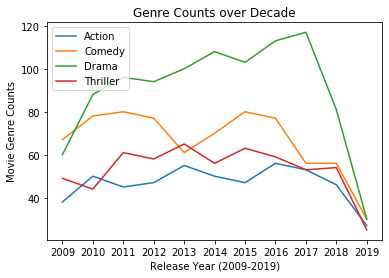

In [20]:
Action_plot, = plt.plot(group_genre_T.index, group_genre_T['Action'])
Comedy_plot, = plt.plot(group_genre_T.index, group_genre_T['Comedy'])
Drama_plot, = plt.plot(group_genre_T.index, group_genre_T['Drama'])
Thriller_plot, = plt.plot(group_genre_T.index, group_genre_T['Thriller'])

plt.xlabel('Release Year (2009-2019)')
plt.ylabel('Movie Genre Counts')
plt.title('Genre Counts over Decade')
plt.legend((Action_plot,Comedy_plot,Drama_plot,Thriller_plot),('Action','Comedy','Drama','Thriller'),loc=2)

plt.savefig("Output_Data/Release_vs_Genre.png")
plt.show()

* Filtered by top 4 of mostly produced genres that shows trends over the decade.
* As cliche as it sounds, Action movie is the way to go.
* One thing to note: 2019's data is incomplete yet and many data were dropped due to missing values, so sudden drops in 2019 isn't necessarily true.

In [21]:
#Drop the null values in the subset
set1=["Title","Popularity","Run Time","Vote Average","IMDB Rating","Metascore"]
#Check data 
df_runtime=df[set1].dropna().reset_index(drop=True)
df_runtime.head()

,Title,Popularity,Run Time,Vote Average,IMDB Rating,Metascore
0,Joker,601.364,122.0,8.6,8.9,59.0
1,The Lion King,180.573,118.0,7.1,7.1,55.0
2,Spider-Man: Far from Home,149.478,129.0,7.6,7.7,69.0
3,Fast & Furious Presents: Hobbs & Shaw,117.194,137.0,6.5,6.7,60.0
4,Toy Story 4,105.512,100.0,7.6,8.1,84.0


In [22]:
#Remove the outlier
df_runtime=df_runtime.loc[df_runtime['Popularity']!=df_runtime['Popularity'].max()]

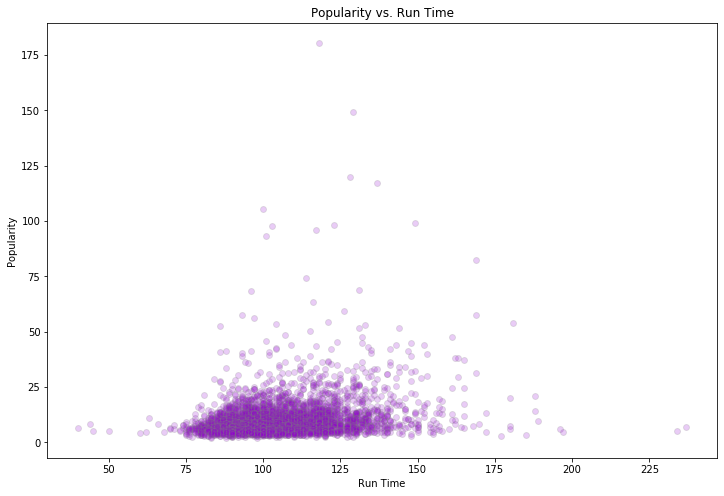

In [23]:
#set axis and tick locations
x_axis=df_runtime["Run Time"]
plt.figure(figsize=(12,8))
plt.scatter(x_axis,df_runtime["Popularity"], facecolor = "darkviolet", edgecolor = "grey", alpha = 0.2)
# Set a Title and labels
plt.title("Popularity vs. Run Time")
plt.xlabel("Run Time")
plt.ylabel("Popularity")
#plt.tight_layout()
plt.savefig("output_data/POPvsRT.png")
plt.show()

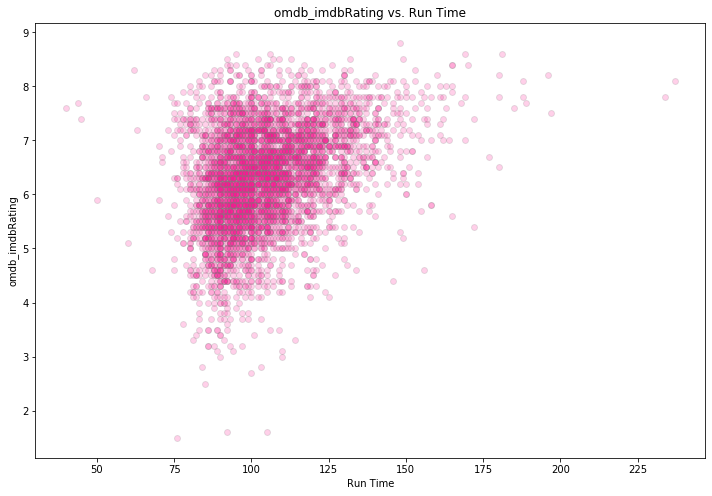

In [24]:
#set axis and tick locations
x_axis=df_runtime["Run Time"]
plt.figure(figsize=(12,8))
plt.scatter(x_axis,df_runtime["IMDB Rating"], facecolor = "deeppink", edgecolor = "grey", alpha = 0.2)
# Set a Title and labels
plt.title("omdb_imdbRating vs. Run Time")
plt.xlabel("Run Time")
plt.ylabel("omdb_imdbRating")
#plt.tight_layout()
plt.savefig("output_data/RatingvsRT.png")
plt.show()

In [25]:
#Drop the null values in the subset
set2=["Title","Budget","Revenue","Popularity","IMDB Rating","IMDB Votes","Genre1","Genre2","Genre3","Genre4","Genre5","Genre6","Genre7"]
set3=["Title","Popularity","IMDB Rating","IMDB Votes","Budget","Revenue"]
df_set2=df[set2].dropna(subset=(set3)).set_index("Title")
df_set2.head()

,Budget,Revenue,Popularity,IMDB Rating,IMDB Votes,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7
Title,,,,,,,,,,,,
Joker,55000000.0,7.883000e+08,601.364,8.9,"360,218",Crime,Thriller,Drama,NaN,NaN,NaN,NaN
The Lion King,260000000.0,1.649677e+09,180.573,7.1,"102,621",Adventure,Animation,Drama,NaN,NaN,NaN,NaN
Spider-Man: Far from Home,160000000.0,1.131450e+09,149.478,7.7,"187,214",Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN
Fast & Furious Presents: Hobbs & Shaw,200000000.0,7.600990e+08,117.194,6.7,"74,896",Action,NaN,NaN,NaN,NaN,NaN,NaN
Toy Story 4,175000000.0,5.198028e+08,105.512,8.1,"96,147",Adventure,Animation,Comedy,Family,Fantasy,NaN,NaN


In [26]:
#Test

In [27]:
#Collect Data Based on Genre
df_genre1_count=df_set2.groupby("Genre1")["Popularity"].count().reset_index(name="Counts1").set_index("Genre1")
df_genre1_pop=df_set2.groupby("Genre1")["Popularity"].sum().reset_index(name="Popularity Sum1").set_index('Genre1')
df_genre1_imdbr=df_set2.groupby("Genre1")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum1").set_index('Genre1')
df_genre1_budget=df_set2.groupby("Genre1")["Budget"].sum().reset_index(name="Budget Sum1").set_index('Genre1')
df_genre1_revenue=df_set2.groupby("Genre1")["Revenue"].sum().reset_index(name="Revenue Sum1").set_index('Genre1')

df_genre2_count=df_set2.groupby("Genre2")["Popularity"].count().reset_index(name="Counts2").set_index("Genre2")
df_genre2_pop=df_set2.groupby("Genre2")["Popularity"].sum().reset_index(name="Popularity Sum2").set_index('Genre2')
df_genre2_imdbr=df_set2.groupby("Genre2")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum2").set_index('Genre2')
df_genre2_budget=df_set2.groupby("Genre2")["Budget"].sum().reset_index(name="Budget Sum2").set_index('Genre2')
df_genre2_revenue=df_set2.groupby("Genre2")["Revenue"].sum().reset_index(name="Revenue Sum2").set_index('Genre2')

df_genre3_count=df_set2.groupby("Genre3")["Popularity"].count().reset_index(name="Counts3").set_index("Genre3")
df_genre3_pop=df_set2.groupby("Genre3")["Popularity"].sum().reset_index(name="Popularity Sum3").set_index('Genre3')
df_genre3_imdbr=df_set2.groupby("Genre3")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum3").set_index('Genre3')
df_genre3_budget=df_set2.groupby("Genre3")["Budget"].sum().reset_index(name="Budget Sum3").set_index('Genre3')
df_genre3_revenue=df_set2.groupby("Genre3")["Revenue"].sum().reset_index(name="Revenue Sum3").set_index('Genre3')

df_genre4_count=df_set2.groupby("Genre4")["Popularity"].count().reset_index(name="Counts4").set_index("Genre4")
df_genre4_pop=df_set2.groupby("Genre4")["Popularity"].sum().reset_index(name="Popularity Sum4").set_index('Genre4')
df_genre4_imdbr=df_set2.groupby("Genre4")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum4").set_index('Genre4')
df_genre4_budget=df_set2.groupby("Genre4")["Budget"].sum().reset_index(name="Budget Sum4").set_index('Genre4')
df_genre4_revenue=df_set2.groupby("Genre4")["Revenue"].sum().reset_index(name="Revenue Sum4").set_index('Genre4')

df_genre5_count=df_set2.groupby("Genre5")["Popularity"].count().reset_index(name="Counts5").set_index("Genre5")
df_genre5_pop=df_set2.groupby("Genre5")["Popularity"].sum().reset_index(name="Popularity Sum5").set_index('Genre5')
df_genre5_imdbr=df_set2.groupby("Genre5")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum5").set_index('Genre5')
df_genre5_budget=df_set2.groupby("Genre5")["Budget"].sum().reset_index(name="Budget Sum5").set_index('Genre5')
df_genre5_revenue=df_set2.groupby("Genre5")["Revenue"].sum().reset_index(name="Revenue Sum5").set_index('Genre5')

df_genre6_count=df_set2.groupby("Genre6")["Popularity"].count().reset_index(name="Counts6").set_index("Genre6")
df_genre6_pop=df_set2.groupby("Genre6")["Popularity"].sum().reset_index(name="Popularity Sum6").set_index('Genre6')
df_genre6_imdbr=df_set2.groupby("Genre6")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum6").set_index('Genre6')
df_genre6_budget=df_set2.groupby("Genre6")["Budget"].sum().reset_index(name="Budget Sum6").set_index('Genre6')
df_genre6_revenue=df_set2.groupby("Genre6")["Revenue"].sum().reset_index(name="Revenue Sum6").set_index('Genre6')

df_genre7_count=df_set2.groupby("Genre7")["Popularity"].count().reset_index(name="Counts7").set_index("Genre7")
df_genre7_pop=df_set2.groupby("Genre7")["Popularity"].sum().reset_index(name="Popularity Sum7").set_index('Genre7')
df_genre7_imdbr=df_set2.groupby("Genre7")["IMDB Rating"].sum().reset_index(name="IMDB Rating Sum7").set_index('Genre7')
df_genre7_budget=df_set2.groupby("Genre7")["Budget"].sum().reset_index(name="Budget Sum7").set_index('Genre7')
df_genre7_revenue=df_set2.groupby("Genre7")["Revenue"].sum().reset_index(name="Revenue Sum7").set_index('Genre7')

df_genre=pd.concat([df_genre1_count,df_genre1_pop,df_genre1_imdbr,df_genre1_budget,df_genre1_revenue,
                    df_genre2_count,df_genre2_pop,df_genre2_imdbr,df_genre2_budget,df_genre2_revenue,
                    df_genre3_count,df_genre3_pop,df_genre3_imdbr,df_genre3_budget,df_genre3_revenue,
                    df_genre4_count,df_genre4_pop,df_genre4_imdbr,df_genre4_budget,df_genre4_revenue,
                    df_genre5_count,df_genre5_pop,df_genre5_imdbr,df_genre5_budget,df_genre5_revenue,
                    df_genre6_count,df_genre6_pop,df_genre6_imdbr,df_genre6_budget,df_genre6_revenue,
                    df_genre7_count,df_genre7_pop,df_genre7_imdbr,df_genre7_budget,df_genre7_revenue],axis=1)

In [28]:
df_genre_count=df_genre[["Counts1","Counts2","Counts3","Counts4","Counts5","Counts6","Counts7"]].sum(axis=1)
df_genre_count=df_genre_count.reset_index(name="Counts").set_index('index')

df_genre_Popularity=df_genre[["Popularity Sum1","Popularity Sum2","Popularity Sum3","Popularity Sum4",
                              "Popularity Sum5","Popularity Sum6","Popularity Sum7"]].sum(axis=1)/df_genre_count["Counts"]
df_genre_Popularity=df_genre_Popularity.reset_index(name="Average Popularity").set_index('index')

df_genre_imdbr=df_genre[["IMDB Rating Sum1","IMDB Rating Sum2","IMDB Rating Sum3","IMDB Rating Sum4",
                         "IMDB Rating Sum5","IMDB Rating Sum6","IMDB Rating Sum7"]].sum(axis=1)/df_genre_count["Counts"]
df_genre_imdbr=df_genre_imdbr.reset_index(name="Average IMDB Rating").set_index('index')

df_genre_budget=df_genre[["Budget Sum1","Budget Sum2","Budget Sum3","Budget Sum4",
                         "Budget Sum5","Budget Sum6","Budget Sum7"]].sum(axis=1)/df_genre_count["Counts"]
df_genre_budget=df_genre_budget.reset_index(name="Average Budget").set_index('index')

df_genre_revenue=df_genre[["Revenue Sum1","Revenue Sum2","Revenue Sum3","Revenue Sum4",
                         "Revenue Sum5","Revenue Sum6","Revenue Sum7"]].sum(axis=1)/df_genre_count["Counts"]
df_genre_revenue=df_genre_revenue.reset_index(name="Average Revenue").set_index('index')

df_genre_profit=df_genre_revenue["Average Revenue"]-df_genre_budget["Average Budget"]
df_genre_profit=df_genre_profit.reset_index(name="Average Profit").set_index('index')

df_genre_return=df_genre_profit["Average Profit"]/df_genre_budget["Average Budget"]*100
df_genre_return=df_genre_return.reset_index(name="Return %").set_index('index')
genre_table=pd.concat([df_genre_count,df_genre_Popularity,df_genre_imdbr,df_genre_budget,df_genre_revenue,df_genre_profit,df_genre_return],axis=1).reset_index()
genre_table=genre_table.rename(columns={"index":"Genre"})
genre_table.head()

,Genre,Counts,Average Popularity,Average IMDB Rating,Average Budget,Average Revenue,Average Profit,Return %
0,Action,615.0,16.565759,6.372846,6.899545e+07,2.172599e+08,1.482645e+08,214.890241
1,Adventure,405.0,19.334923,6.489877,9.973407e+07,3.443762e+08,2.446422e+08,245.294479
2,Animation,159.0,17.625818,6.611321,8.078355e+07,2.946372e+08,2.138536e+08,264.724178
3,Comedy,721.0,12.466454,6.297365,3.715512e+07,1.202955e+08,8.314043e+07,223.765724
4,Crime,295.0,14.692746,6.494576,3.171492e+07,8.068533e+07,4.897040e+07,154.408081


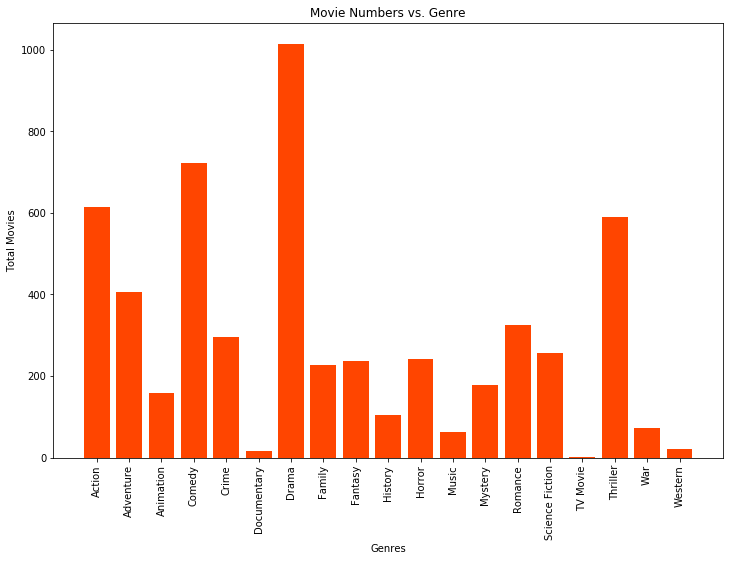

In [29]:
#set axis and tick locations
x_axis=genre_table["Genre"]
plt.figure(figsize=(12,8))
plt.bar(x_axis,genre_table["Counts"],color="orangered")
# Set a Title and labels
plt.title("Movie Numbers vs. Genre")
plt.xlabel("Genres")
plt.ylabel("Total Movies")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.savefig("output_data/num_movie vs Genre.png")
plt.show()

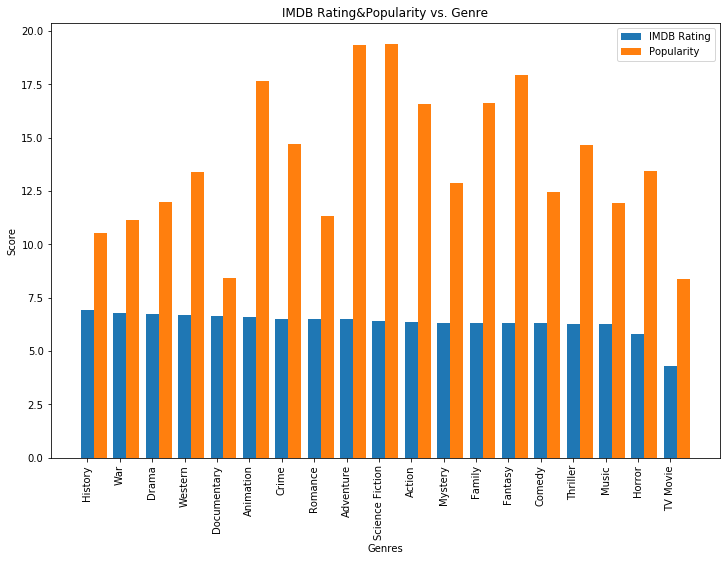

In [39]:
genre_table_2 = genre_table.set_index("Genre")
genre_table_rating=genre_table_2.sort_values(by=["Average IMDB Rating"],ascending=False)
x_range = np.arange(0,38,2)
plt.figure(figsize = (12,8))
plt.bar(x_range, genre_table_rating["Average IMDB Rating"],label='IMDB Rating')
plt.bar(x_range+0.8, genre_table_rating["Average Popularity"],label='Popularity')
plt.xticks(x_range, genre_table_rating.index, rotation = 90)
plt.legend( loc='upper right')
plt.title("IMDB Rating&Popularity vs. Genre")
plt.xlabel("Genres")
plt.ylabel("Score")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.savefig("output_data/IMDB Rating&Popularity vs Genre.png")
plt.show()

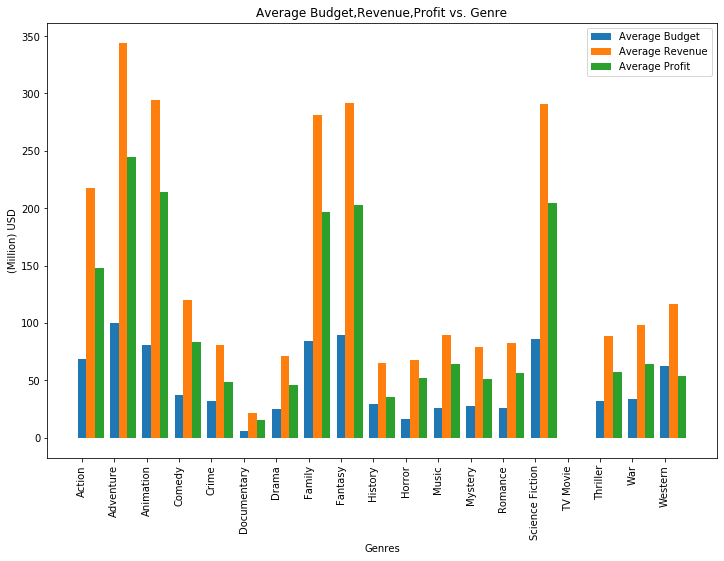

In [31]:
genre_table_2 = genre_table.set_index("Genre")
x_range = np.arange(0,57,3)
plt.figure(figsize = (12,8))
plt.bar(x_range, genre_table_2["Average Budget"]/1000000,label='Average Budget')
plt.bar(x_range+0.8, genre_table_2["Average Revenue"]/1000000,label='Average Revenue')
plt.bar(x_range+1.6, genre_table_2["Average Profit"]/1000000,label='Average Profit')

plt.xticks(x_range, genre_table_2.index, rotation = 90)
plt.legend( loc='upper right')
plt.title("Average Budget,Revenue,Profit vs. Genre")
plt.xlabel("Genres")
plt.ylabel("(Million) USD")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.savefig("output_data/Average_Budget,Revenue,Profit vs Genre.png")
plt.show()

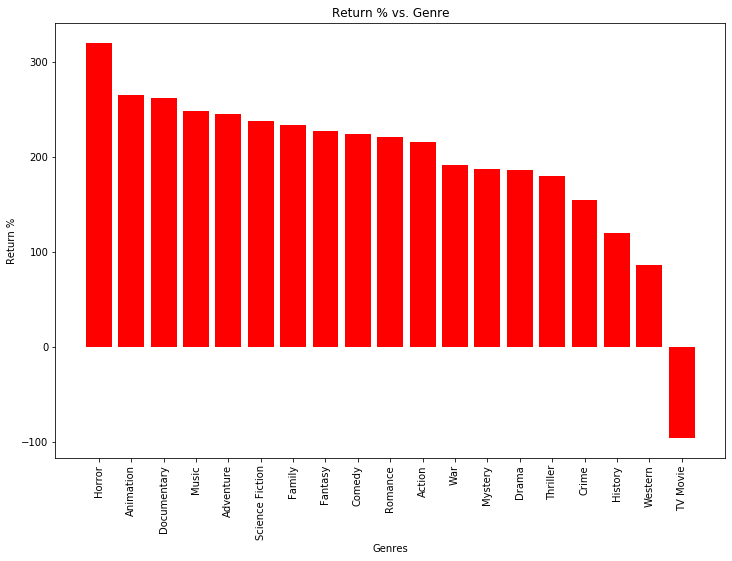

In [32]:
#set axis and tick locations
genre_table_profit=genre_table.sort_values(by=["Return %"],ascending=False)
x_axis=genre_table_profit["Genre"]
plt.figure(figsize=(12,8))
plt.bar(x_axis,genre_table_profit["Return %"],color="red")
# Set a Title and labels
plt.title("Return % vs. Genre")
plt.xlabel("Genres")
plt.ylabel("Return %")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.savefig("output_data/Return % vs Genre.png")
plt.show()

In [33]:
df_new = pd.read_csv("output_data/cleanup_movie_2019.csv")
df_new = df_new[["Budget", "Revenue", "Vote Average"]]
df_new = df_new.replace(0,np.nan)
df_new = df_new.dropna()
df_new = df_new.reset_index(drop=True)

#### Budget VS Average Vote

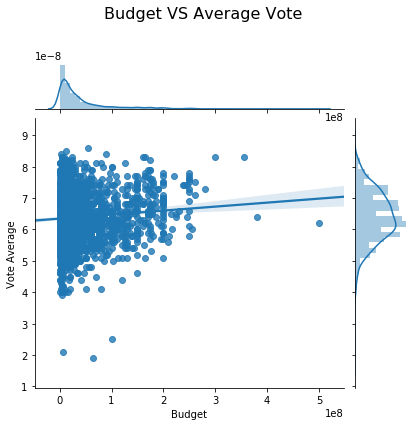

In [34]:
g = sns.jointplot("Budget", "Vote Average", data=df_new, kind="reg")
g.fig.subplots_adjust(top=.85)
g.fig.suptitle('Budget VS Average Vote', fontsize=16)
plt.savefig("output_data/Average Vote vs Budget.png",dpi=300) #added
plt.show()

#### Revenue VS Average Vote

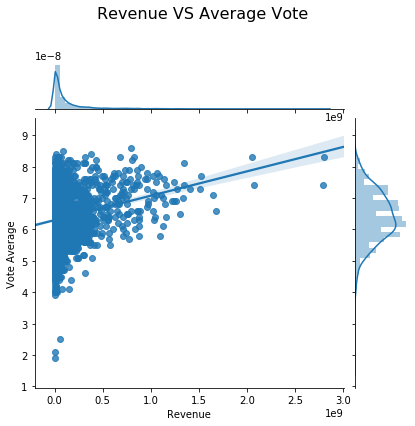

In [35]:
g = sns.jointplot("Revenue", "Vote Average", data=df_new, kind="reg")
g.fig.subplots_adjust(top=.85)
g.fig.suptitle('Revenue VS Average Vote', fontsize=16)
plt.savefig("output_data/Average Vote vs Revenue.png",dpi=300) #added
plt.show()

#### Profitable VS Average Vote

In [36]:
df_new["Profit"] = df_new["Revenue"]-df_new["Budget"]
df_new["Profitable"] = df_new["Revenue"]-df_new["Budget"]

df_new.loc[df_new.Profit <= 0, 'Profitable'] = 'Not Profitable' 
df_new.loc[df_new.Profit > 0, 'Profitable'] = 'Profitable'

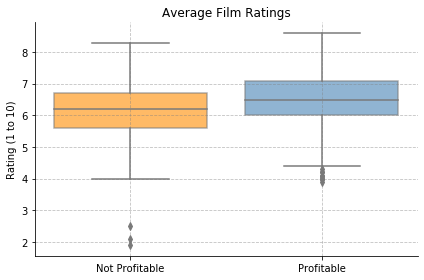

In [37]:
ratings_boxplot=sns.boxplot(x="Profitable",y="Vote Average",data=df_new, palette="coolwarm", order=["Not Profitable","Profitable"], boxprops=dict(alpha=0.6))
# Change the facecolors to be consistent with the other charts
ratings_boxplot.artists[0].set_facecolor("darkorange")
ratings_boxplot.artists[1].set_facecolor("steelblue")

plt.grid(True,color="grey",linestyle="--",alpha=0.5)
sns.despine()
plt.xlabel("")
plt.ylabel("Rating (1 to 10)")
plt.title("Average Film Ratings")
plt.tight_layout()

# Show chart and save
plt.savefig("output_data/film_ratings_boxplot.png")
plt.show()